In [1]:
import torch
import gpytorch
import numpy as np
import optuna
import matplotlib.pyplot as plt
from src.plotting import plot_gp, plot_alpha_beta, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ExactGPModel, BetaGP
from src.beta_likelihood import BetaLikelihood_MeanParametrization
from optuna.visualization import plot_optimization_history, plot_param_importances

In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



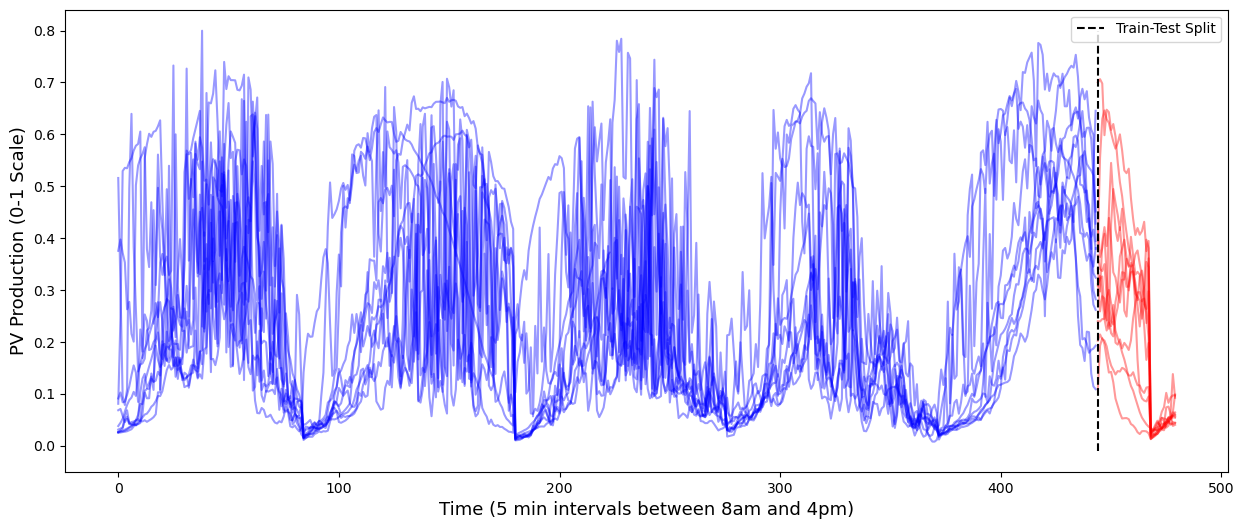

In [3]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=3)
plot_train_test_split(y_train, y_test)

In [28]:
# get individual time series
y_in = y

if y_in.max() > 1:
    y_in[y_in > 1] = 1
# get time related variables
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize input
x = (x - x.mean(dim=0)) / x.std(dim=0)

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=3)

# use all data as inducing points
x_inducing = x_train
y_inducing = y_train

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

# Kernels

In [17]:
study.best_params

{'lengthscale_shape': 7.0,
 'lengthscale_rate': 1.0,
 'scale_shape': 2.0,
 'scale_rate': 3.0,
 'likelihood_scale': 1.0,
 'likelihood_correcting_scale': 1.0,
 'lr': 0.1}

In [31]:
from gpytorch.kernels import MaternKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the period in periodic
matern_base = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.1, 1)
                            )
product_kernel = ScaleKernel(periodic * matern_base,
                             outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                             outputscale_constraint=gpytorch.constraints.Positive()
                            )

quasi_periodic = AdditiveKernel(product_kernel, scaled_matern)


Iter 30/300 - Loss: 0.315
Iter 60/300 - Loss: -0.382
Iter 90/300 - Loss: -0.607
Iter 120/300 - Loss: -0.694
Iter 150/300 - Loss: -0.733
Iter 180/300 - Loss: -0.753
Iter 210/300 - Loss: -0.766
Iter 240/300 - Loss: -0.774
Iter 270/300 - Loss: -0.780
Iter 300/300 - Loss: -0.785


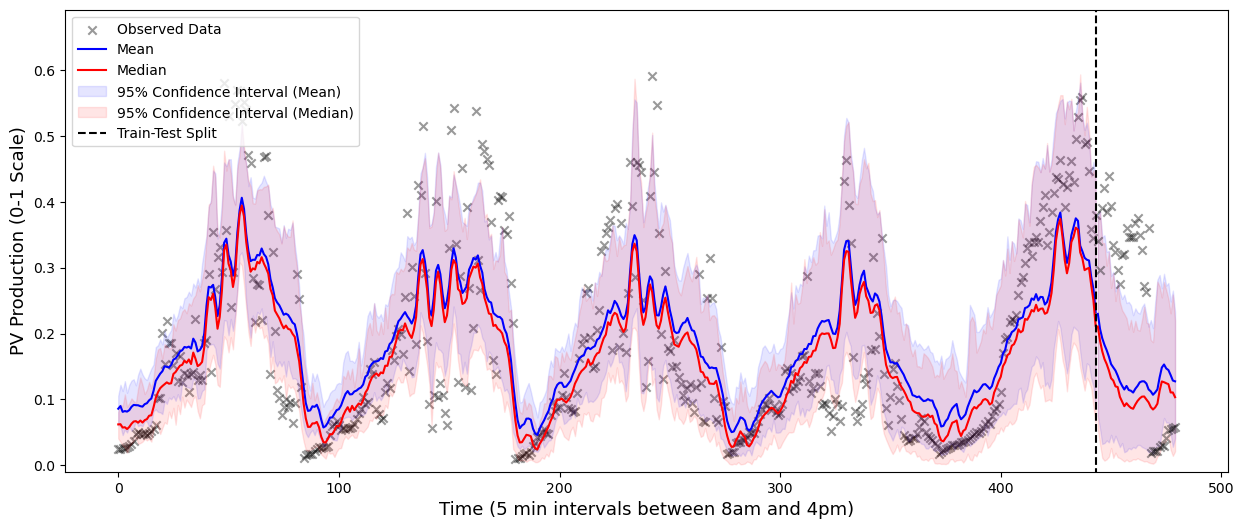

Iter 30/300 - Loss: 0.180
Iter 60/300 - Loss: -0.480
Iter 90/300 - Loss: -0.719
Iter 120/300 - Loss: -0.821
Iter 150/300 - Loss: -0.870
Iter 180/300 - Loss: -0.899
Iter 210/300 - Loss: -0.920
Iter 240/300 - Loss: -0.936
Iter 270/300 - Loss: -0.949
Iter 300/300 - Loss: -0.959


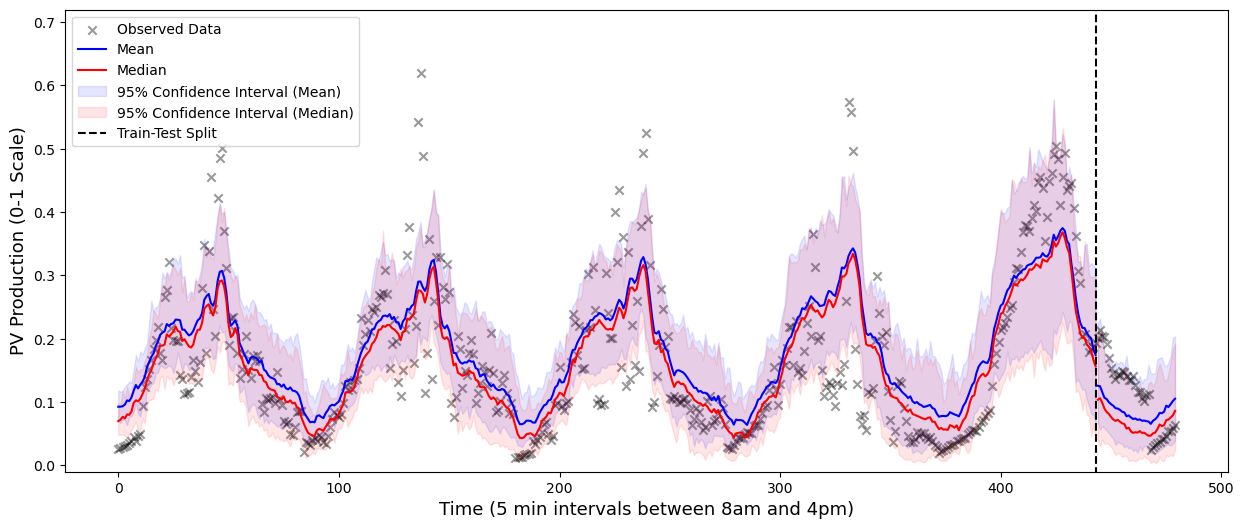

Iter 30/300 - Loss: 0.190
Iter 60/300 - Loss: -0.427
Iter 90/300 - Loss: -0.604
Iter 120/300 - Loss: -0.667
Iter 150/300 - Loss: -0.697
Iter 180/300 - Loss: -0.714
Iter 210/300 - Loss: -0.727
Iter 240/300 - Loss: -0.803
Iter 270/300 - Loss: -0.855
Iter 300/300 - Loss: -0.877


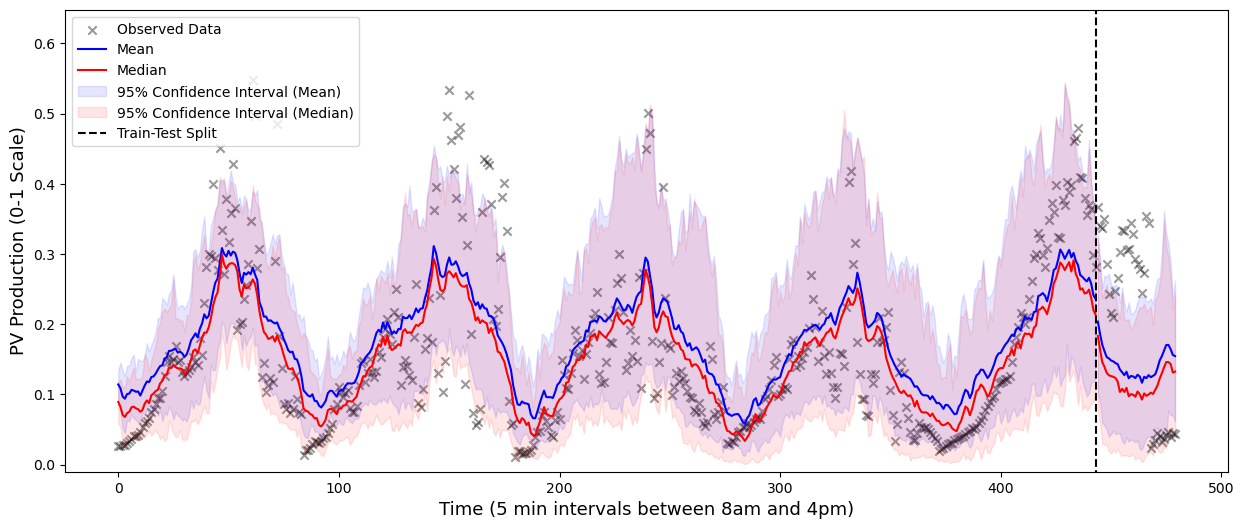

Iter 30/300 - Loss: 0.507
Iter 60/300 - Loss: -0.190
Iter 90/300 - Loss: -0.391
Iter 120/300 - Loss: -0.486
Iter 150/300 - Loss: -0.654
Iter 180/300 - Loss: -0.712
Iter 210/300 - Loss: -0.744
Iter 240/300 - Loss: -0.765
Iter 270/300 - Loss: -0.780
Iter 300/300 - Loss: -0.791


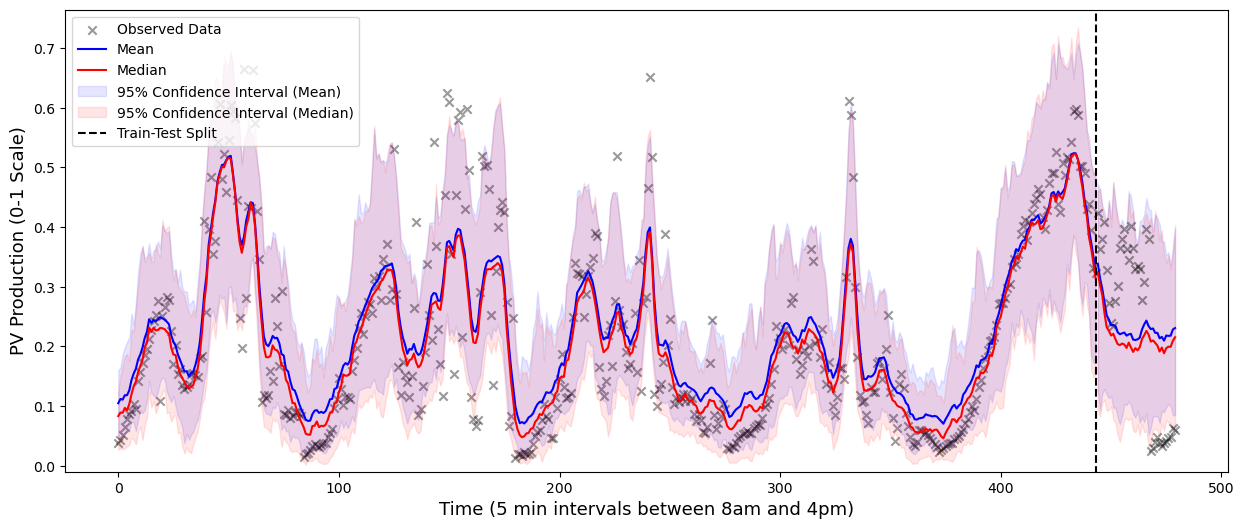

Iter 30/300 - Loss: -0.151
Iter 60/300 - Loss: -0.463
Iter 90/300 - Loss: -0.509
Iter 120/300 - Loss: -0.524
Iter 150/300 - Loss: -0.534
Iter 180/300 - Loss: -0.541
Iter 210/300 - Loss: -0.547
Iter 240/300 - Loss: -0.550
Iter 270/300 - Loss: -0.553
Iter 300/300 - Loss: -0.555


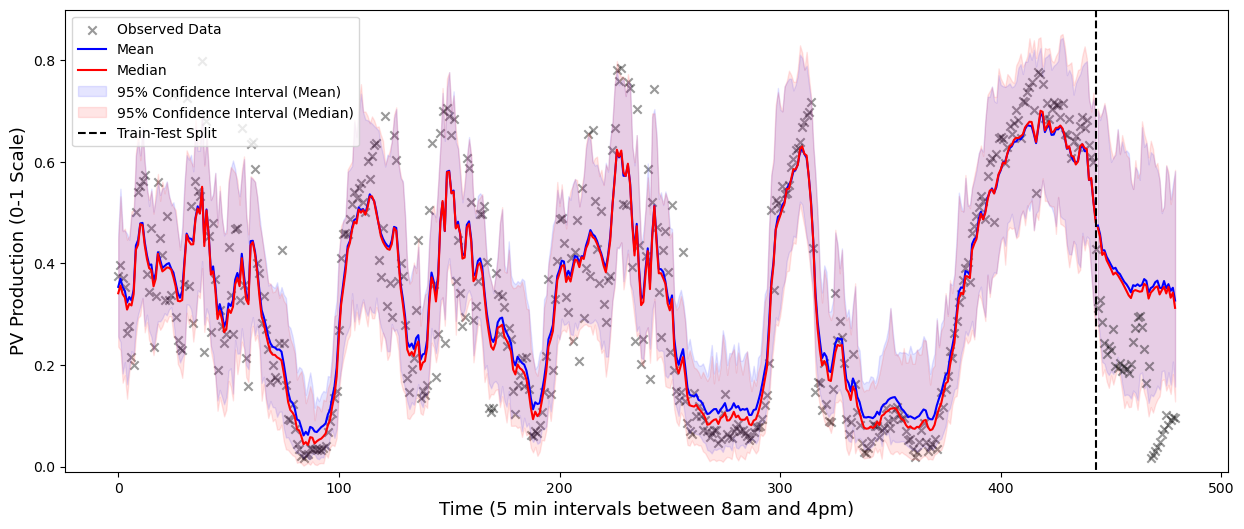

Iter 30/300 - Loss: -0.319
Iter 60/300 - Loss: -0.733
Iter 90/300 - Loss: -0.808
Iter 120/300 - Loss: -0.840
Iter 150/300 - Loss: -0.861
Iter 180/300 - Loss: -0.877
Iter 210/300 - Loss: -0.889
Iter 240/300 - Loss: -0.899
Iter 270/300 - Loss: -0.907
Iter 300/300 - Loss: -0.914


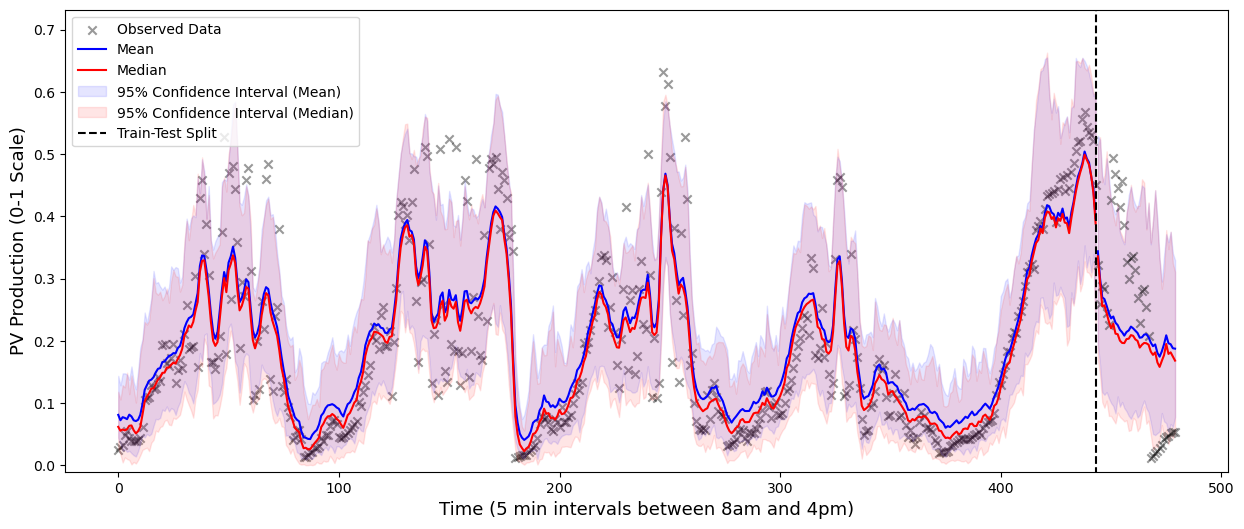

Iter 30/300 - Loss: -0.298
Iter 60/300 - Loss: -0.640
Iter 90/300 - Loss: -0.695
Iter 120/300 - Loss: -0.720
Iter 150/300 - Loss: -0.737
Iter 180/300 - Loss: -0.750
Iter 210/300 - Loss: -0.759
Iter 240/300 - Loss: -0.767
Iter 270/300 - Loss: -0.772
Iter 300/300 - Loss: -0.777


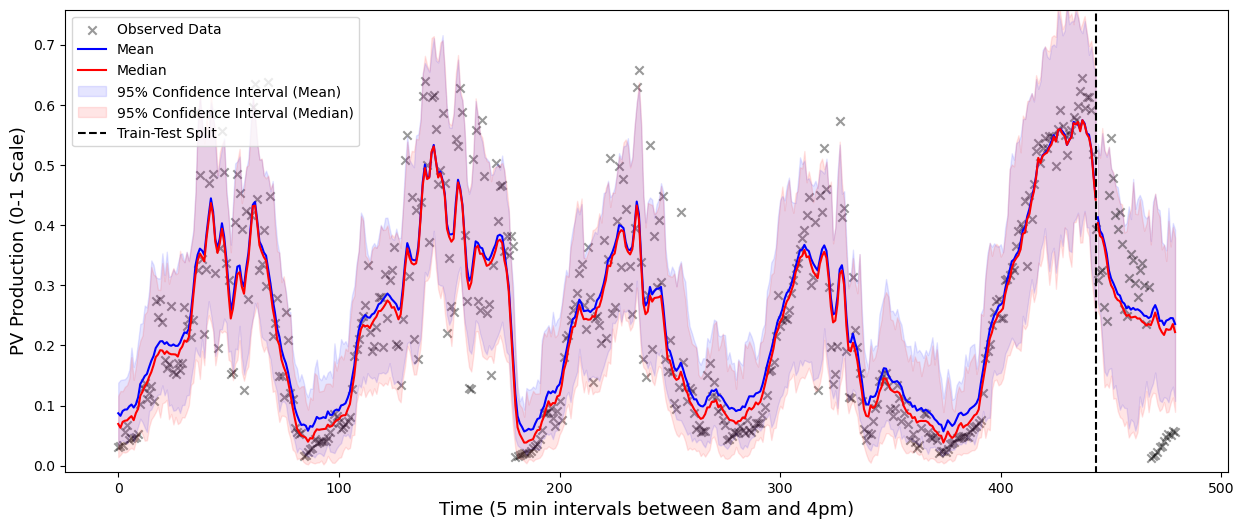

Iter 30/300 - Loss: -0.186
Iter 60/300 - Loss: -0.532
Iter 90/300 - Loss: -0.602
Iter 120/300 - Loss: -0.633
Iter 150/300 - Loss: -0.655
Iter 180/300 - Loss: -0.670
Iter 210/300 - Loss: -0.682
Iter 240/300 - Loss: -0.691
Iter 270/300 - Loss: -0.699
Iter 300/300 - Loss: -0.705


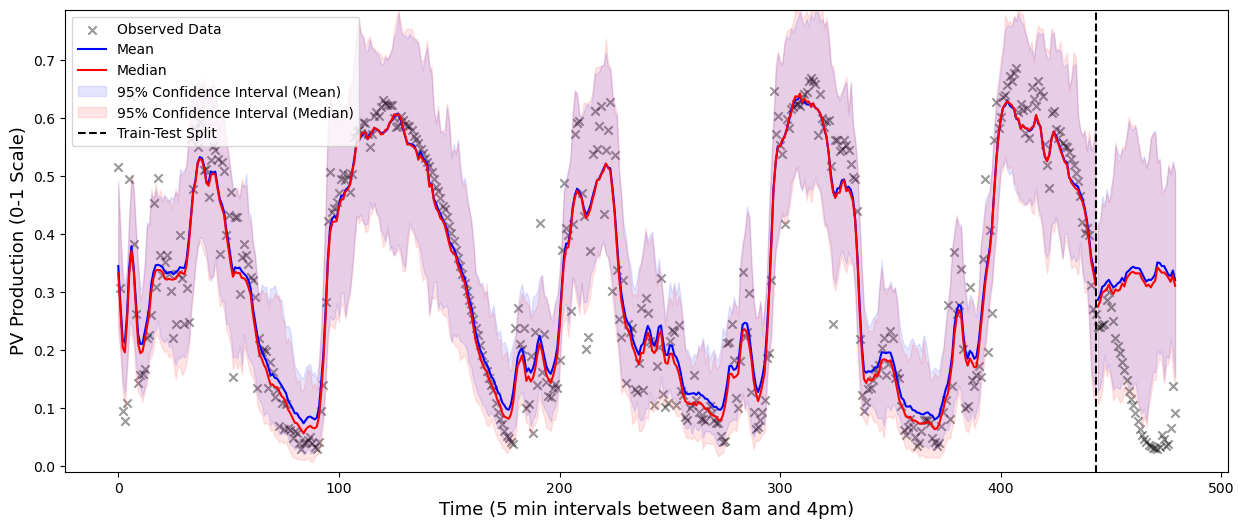

Iter 30/300 - Loss: -0.249
Iter 60/300 - Loss: -0.644
Iter 90/300 - Loss: -0.724
Iter 120/300 - Loss: -0.759
Iter 150/300 - Loss: -0.782
Iter 180/300 - Loss: -0.799
Iter 210/300 - Loss: -0.812
Iter 240/300 - Loss: -0.823
Iter 270/300 - Loss: -0.832
Iter 300/300 - Loss: -0.839


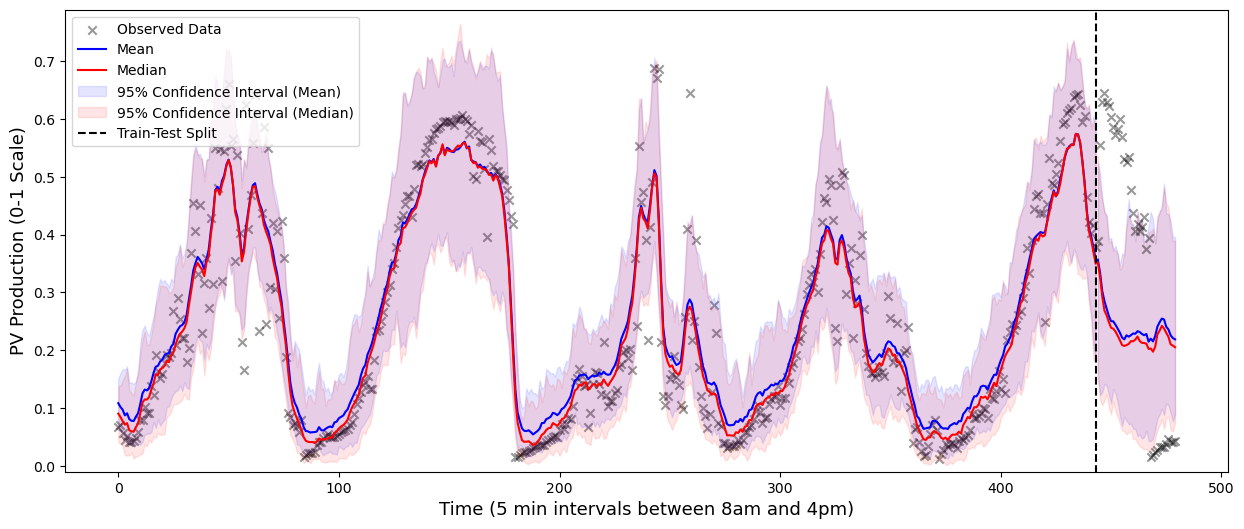

Iter 30/300 - Loss: -0.172
Iter 60/300 - Loss: -0.559
Iter 90/300 - Loss: -0.627
Iter 120/300 - Loss: -0.660
Iter 150/300 - Loss: -0.682
Iter 180/300 - Loss: -0.698
Iter 210/300 - Loss: -0.710
Iter 240/300 - Loss: -0.720
Iter 270/300 - Loss: -0.728
Iter 300/300 - Loss: -0.734


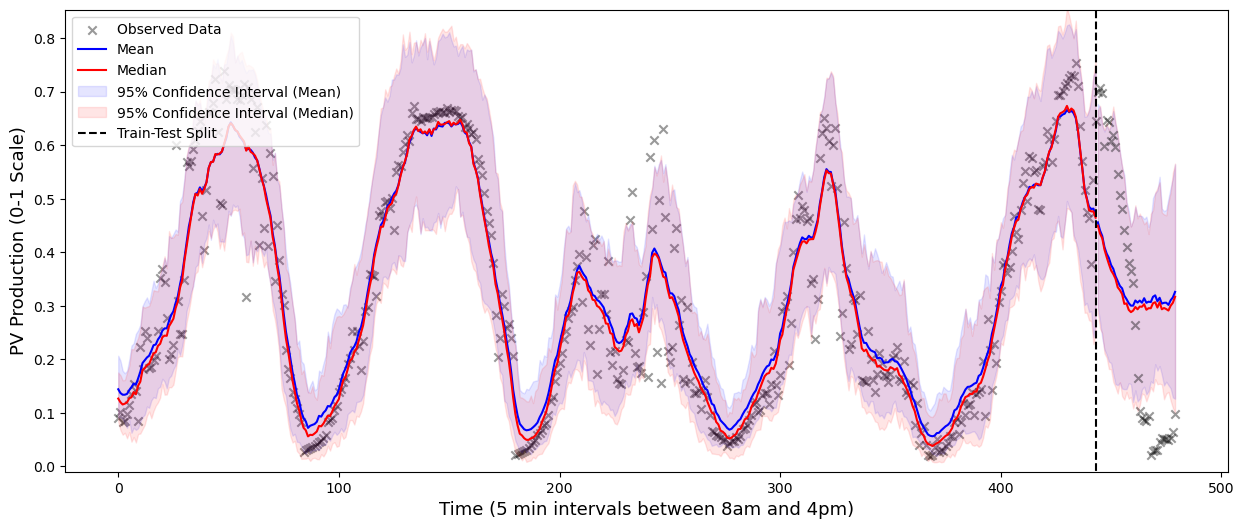

Iter 30/300 - Loss: -0.201
Iter 60/300 - Loss: -0.582
Iter 90/300 - Loss: -0.660
Iter 120/300 - Loss: -0.692
Iter 150/300 - Loss: -0.711
Iter 180/300 - Loss: -0.726
Iter 210/300 - Loss: -0.737
Iter 240/300 - Loss: -0.745
Iter 270/300 - Loss: -0.752
Iter 300/300 - Loss: -0.757


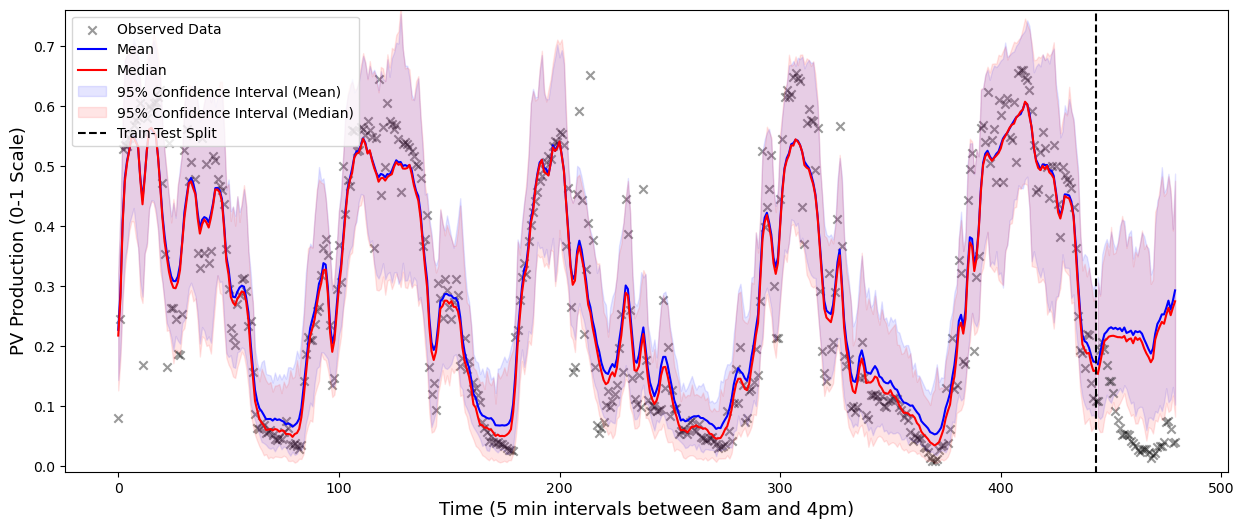

In [32]:
jitter = 1e-4

for idx in range(y_train.size(1)):
    
    config = {  'type': 'stochastic',
                'name': 'mean_field',
                'num_inducing_points': x_inducing.size(0),
                'mean_init_std': 2,
                }
    inputs_mean = { 'X': x_train, 'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': quasi_periodic,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=6,
                                                                     correcting_scale=1,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = BetaGP(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)    
    
    preds = model_beta.predict(x, device=torch.device('cpu'))
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], y_inducing=y_inducing[:,idx])


# Hyperparameter Optimization

In [8]:
from src.hyperparameter_tuning import HyperParameterOptimization

In [9]:
config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-5

hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter), n_trials=60)

[I 2023-06-22 21:09:24,112] A new study created in memory with name: no-name-fd0fdc17-f0d5-4be4-9cbb-eb80e7fa055a
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46.0].
  warnings.warn(
[I 2023-06-22 21:11:57,574] Trial 0 finished with value: 0.03090612217783928 and parameters: {'lengthscale_shape': 10.0, 'lengthscale_rate': 1.0, 'scale_shape': 9.0, 'scale_rate': 5.0, 'likelihood_scale': 16.0, 'likelihood_correcting_scale': 2.0, 'lr': 0.30000000000000004}. Best is trial 0 with value: 0.03090612217783928.
[I 2023-06-22 21:14:30,785] Trial 1 finished with value: 0.08988427370786667 and parameters: {'lengthscale_shape': 5.0, 'lengthscale_rate': 7.0, 'scale_shape': 8.0, 'scale_rate': 4.0, 'likelihood_scale': 41.0, 'likelihood_correcting_scale': 3.0, 'lr': 0.1}. Best is trial 0 with value: 0.030906122177

In [10]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_parallel_coordinate, plot_param_importances

In [11]:
plot_optimization_history(study)

In [12]:
plot_contour(study, params=[ 'lengthscale_rate', 'lengthscale_shape'])

In [13]:
plot_parallel_coordinate(study)

In [14]:
plot_param_importances(study)

In [15]:
best_params = study.best_params
best_params

{'lengthscale_shape': 7.0,
 'lengthscale_rate': 1.0,
 'scale_shape': 2.0,
 'scale_rate': 3.0,
 'likelihood_scale': 1.0,
 'likelihood_correcting_scale': 1.0,
 'lr': 0.1}